In [75]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)

2.9.2


In [76]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [77]:
image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_pred_file = "concept_prediction_train.csv"
concept_file = "concepts.csv"

In [78]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Hackaton
#!unzip resized_train.zip

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Hackaton


In [79]:
concepts = pd.read_csv(concept_file, sep='\t')
concepts = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()

In [80]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation + "¿"

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [81]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
print("Vocab size:")
print(len(set(result.split())))

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
print("Longest sequence:")
print(len(longest))

Vocab size:
35489
Longest sequence:
391


In [82]:
def load_data(limit=0):
    images = []
    _max = 0
    
    files = [filename for filename in os.listdir(image_dir)]
    if limit != 0:
        files = random.sample(files, limit)
        
    for filename in files:
        name = os.path.splitext(filename)[0]
        if name not in captions:
            continue

        image_path = os.path.join(image_dir, name + ".jpg")
        image = cv2.imread(image_path)

        # Preprocess images
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        
        # Preprocess texts
        text = captions[name]
        text = "[SOS] " + text + " [EOS]"
        text = text_vectorization(captions[name])
        
        images.append((image, text))
            
    return images

def load_dataset(limit=0, test=0.2, val=0.0):
    image_pairs = load_data(limit)
    
    random.shuffle(image_pairs)
    num_test_samples = int(test * len(image_pairs))
    num_val_samples = int(val * len(image_pairs))
    test_pairs = image_pairs[:num_test_samples]
    val_pairs = image_pairs[num_test_samples : num_test_samples + num_val_samples]
    train_pairs = image_pairs[num_test_samples + num_val_samples :]
    
    return train_pairs, val_pairs, test_pairs

def visualize_dataset(dataset, nums=5):
    for n, (i, t) in enumerate(random.sample(dataset, nums)):
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, n + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [83]:
vocab_size = 35491
sequence_length = 393

text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [v for v in captions.values()]
text_vectorization.adapt(train_captions)

In [84]:
ds_train, ds_val, ds_test = load_dataset(1000, test=0.2, val=0.2)

In [85]:
#visualize_dataset(ds_train, 5)

In [86]:
batch_size = 32
epochs = 2

In [87]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [88]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [89]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [90]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [110]:
def CLIP_loss(_, logits):
    n = tf.shape(logits)[0]
    labels = range(n)
    
    loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)
    
    return (loss_img + loss_txt)/2

In [92]:
def CLIP_metric():
    pass

In [93]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(None, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42)(img_input)
    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    
    txt_embed = tfkl.GlobalAveragePooling1D()(txt_embed)
    txt_embed = tfkl.Dense(embed_dim, name="text_encoder")(txt_embed)
    
    img_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(img_embed)
    txt_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(txt_embed)
    
    logits = tfkl.Lambda(lambda x: kb.dot(x[0], kb.transpose(x[1])) * kb.exp(temp))((img_norm, txt_norm))
    
    clip = tfk.Model(inputs=[img_input, txt_input], outputs=logits)
    return clip

In [111]:
model= build_clip()
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 model_22 (Functional)          (None, None, 128)    5120768     ['input_10[0][0]']               
                                                                                                  
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 global_average_pooling1d_4 (Gl  (None, 128)         0           ['model_22[0][0]']        

In [95]:
#tfk.utils.plot_model(model)

In [112]:
model.compile(
    loss = CLIP_loss,
    optimizer = tf.optimizers.Adam(),
    #metrics = ['mse', 'mae']
)

In [97]:
ds_train_i = [tf.convert_to_tensor(e[0]) for e in ds_train]
ds_train_t = [tf.convert_to_tensor(e[1]) for e in ds_train]

ds_val_i = [tf.convert_to_tensor(e[0]) for e in ds_val]
ds_val_t = [tf.convert_to_tensor(e[1]) for e in ds_val]

ds_test_i = [tf.convert_to_tensor(e[0]) for e in ds_test]
ds_test_t = [tf.convert_to_tensor(e[1]) for e in ds_test]

ds_train_i = tf.convert_to_tensor(ds_train_i)
ds_train_t = tf.convert_to_tensor(ds_train_t)
ds_val_i = tf.convert_to_tensor(ds_val_i)
ds_val_t = tf.convert_to_tensor(ds_val_t)
ds_test_i = tf.convert_to_tensor(ds_test_i)
ds_test_t = tf.convert_to_tensor(ds_test_t)
    

In [113]:
model.fit(
    x = [ds_train_i, ds_train_t],
    y = np.ones((600, 600)),
    validation_data=([ds_val_i, ds_val_t], np.ones((200, 200))),
    batch_size = batch_size,
    epochs = epochs,
    #callbacks = [
    #    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    #]
)

Epoch 1/2
19/19 [==============================] - 75s 4s/step - loss: 3.4551 - val_loss: 3.4103
Epoch 2/2
19/19 [==============================] - 73s 4s/step - loss: 3.4542 - val_loss: 3.4103


In [99]:
model_i = tfk.Model(inputs=model.get_layer("image_encoder").input, outputs=model.get_layer("image_encoder").output)
model_t = tfk.Model(inputs=model.input[1], outputs=model.get_layer("text_encoder").output)

In [100]:
#p = model.predict([ds_test_i, ds_test_t])
pi = model_i.predict(ds_train_i[:100])
pt = model_t.predict(ds_train_t[:100])

4/4 [==============================] - 2s 484ms/step


In [102]:
pi.shape

(100, 128)

In [103]:
pi /= np.linalg.norm(pi, axis=-1, keepdims=True)
pt /= np.linalg.norm(pt, axis=-1, keepdims=True)
similarity = np.dot(pt, pi.T)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

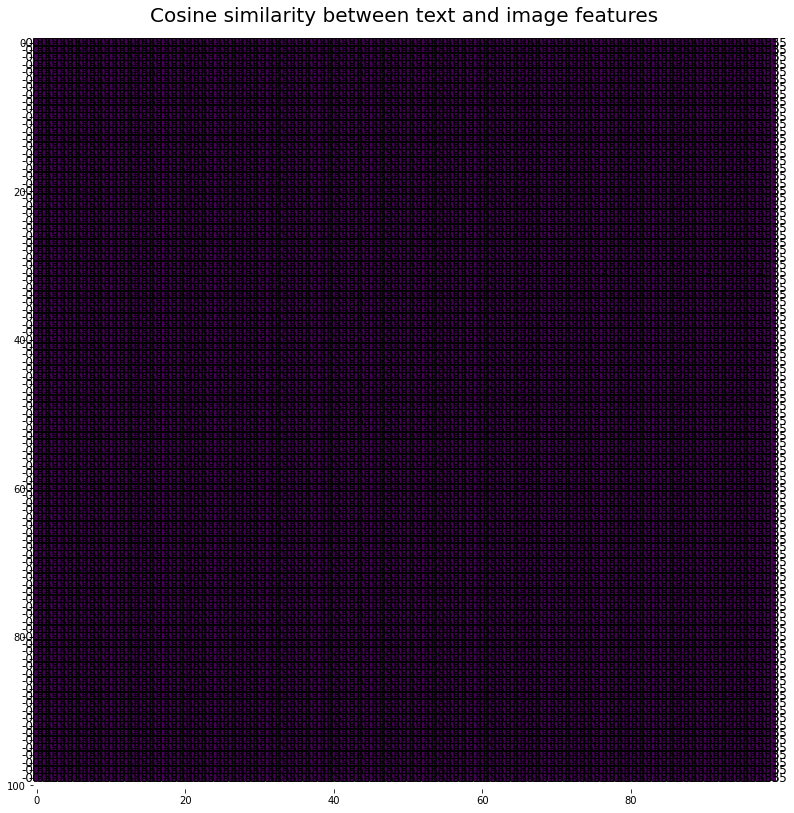

In [104]:
count = 100

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [105]:
print(similarity)

[[-0.35218242 -0.35156983 -0.3517514  ... -0.35183853 -0.35263288
  -0.3515812 ]
 [-0.35211918 -0.35150963 -0.3516928  ... -0.3517757  -0.35256758
  -0.35151795]
 [-0.35259134 -0.35197896 -0.3521551  ... -0.35225073 -0.3530459
  -0.3519928 ]
 ...
 [-0.3526603  -0.3520514  -0.35222954 ... -0.35231858 -0.353111
  -0.35206062]
 [-0.35292006 -0.35230765 -0.35248664 ... -0.35257706 -0.3533716
  -0.35231888]
 [-0.35197818 -0.35136575 -0.35154682 ... -0.35163522 -0.3524307
  -0.35137722]]
